In [1]:
Project = '/Users/daehwa/Library/CloudStorage/OneDrive-Personal/Junlab/Projects/Adipocyte'

from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import copy

plt.rcParams.update(plt.rcParamsDefault)

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

plt.rcParams['ps.useafm']=True
plt.rcParams['pdf.fonttype']=42

plt.rc('font', size=7)          # controls default text sizes
plt.rc('axes', titlesize=7)     # fontsize of the axes title
plt.rc('axes', labelsize=7)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=6)    # fontsize of the tick labels
plt.rc('legend', fontsize=6)    # legend fontsize
suptitlesize = 7

plt.rc('axes', axisbelow=True) #push axes to back
mpl.rcParams['axes.linewidth'] = 0.5

In [2]:
genelist = pd.DataFrame({'gene_id':['ENSMUSG00000026103','ENSMUSG00000026473','ENSMUSG00000021794','ENSMUSG00000025190','ENSMUSG00000031672','ENSMUSG00000031700','ENSMUSG00000030268','ENSMUSG00000030826']})

RNA = pd.read_csv(f'{Project}/Results/Tables/CPM_RD_calculation/v20221217/adi_RNA_log2FC.tsv', sep='\t')
RNA = pd.merge(genelist, RNA, on='gene_id')

RPF = pd.read_csv(f'{Project}/Results/Tables/CPM_RD_calculation/v20221217/adi_RPF_log2FC.tsv', sep='\t')
RPF = pd.merge(genelist, RPF, on='gene_id')

PT = pd.read_csv(f'{Project}/Results/Tables/Proteome/PT_Norm_FC_calculation/v20240403/adi_PT_log2FC.tsv', sep='\t')
PT_conv = pd.read_csv(f'{Project}/Results/Tables/Proteome/adi_proteome_logExp_geneid.tsv', sep='\t', usecols=('uniprot_id','gene_id'))
PT = pd.merge(PT_conv, PT, on='uniprot_id')
PT = pd.merge(genelist, PT, on='gene_id')

# display(RNA)
# display(RPF)
# display(PT)

data = pd.merge(RNA, RPF.drop(columns='gene_name'), on='gene_id')
data = pd.merge(data, PT.drop(columns='uniprot_id'), on='gene_id', how='outer')

display(data)


data_dict = {
    '4d vs 0d' : data[['gene_id','gene_name']+[lib+'4'+rep for lib in ['R','P','PT'] for rep in ['a','b','c']]],
    '8d vs 0d' : data[['gene_id','gene_name']+[lib+'8'+rep for lib in ['R','P','PT'] for rep in ['a','b','c']]]
}
# display(data_dict)

,gene_id,gene_name,R4a,R4b,R4c,R8a,R8b,R8c,P4a,P4b,P4c,P8a,P8b,P8c,PT4a,PT4b,PT4c,PT8a,PT8b,PT8c
0,ENSMUSG00000026103,Gls,-0.713487,-0.036367,-0.567090,-0.883865,-0.515460,-1.269734,-0.550515,0.105618,-0.612894,-0.911967,-0.547633,-1.004796,-0.378226,-0.314387,-0.281349,-0.495496,-0.571194,-0.589513
1,ENSMUSG00000026473,Glul,5.506033,4.637999,5.317854,3.728419,3.756363,3.770626,5.269935,4.715651,5.164211,3.795597,3.848619,3.536591,3.982006,2.885947,4.393462,3.514281,3.866669,4.422909
2,ENSMUSG00000021794,Glud1,2.377190,1.896748,2.373075,0.333735,0.130324,0.205218,2.386314,2.436368,2.745451,0.699081,0.963193,0.812388,2.038421,1.113159,1.865397,1.601760,1.732367,1.378556
3,ENSMUSG00000025190,Got1,0.651563,0.313372,0.468606,1.252468,1.319779,1.049635,0.422223,0.230005,0.569453,1.408328,1.309228,1.093564,0.738100,-0.048551,0.705659,1.732081,1.961422,1.613107
4,ENSMUSG00000031672,Got2,2.387091,1.731559,2.335449,1.011650,1.038017,1.164502,1.981074,1.712160,2.212243,0.968533,0.741930,1.036247,1.299759,0.475616,0.872180,1.452710,1.424050,1.420527
5,ENSMUSG00000031700,Gpt2,2.259083,1.266994,2.100225,0.933617,0.778241,1.220681,2.447106,1.112338,2.282392,1.133665,0.987952,1.535044,1.363095,0.343210,1.169819,0.261286,0.533773,0.726941
6,ENSMUSG00000030268,Bcat1,-2.074593,-0.745576,-1.786023,-2.466784,-2.295907,-2.814047,-1.973738,-0.956569,-1.765162,-2.850899,-2.834397,-2.743153,-1.637198,-0.665156,-1.334313,-1.792309,-1.978235,-1.811955
7,ENSMUSG00000030826,Bcat2,4.266153,3.238221,4.104769,2.698301,3.002480,2.865543,4.188233,3.563133,4.325430,2.927288,2.829929,2.749678,2.745592,1.584054,2.593025,2.606698,2.793663,2.552833


In [3]:
reps = ['a','b','c']

yvalues = []
yerrs = []
xpos = []
bar_c = []

xpos_std = 0
for gene in data.index:
    yvalues += [ np.mean([data.loc[gene,f'{LIB}{Cond}{rep}'] for rep in reps]) for Cond in ['4','8'] for LIB in ['R','P','PT'] ]
    yerrs += [ np.std([data.loc[gene,f'{LIB}{Cond}{rep}'] for rep in reps]) for Cond in ['4','8'] for LIB in ['R','P','PT'] ]

    xpos += list(np.array([0,1,2, 3.2,4.2,5.2]) + xpos_std)
    xpos_std += 6.7

    bar_c += ['#FFCC88','#FFCC88','#FFCC88','#EDA340','#EDA340','#EDA340']


sct_xpos = [xp for xp in xpos for rep in reps]
sct_ypos = [data.loc[gene,f'{LIB}{Cond}{rep}'] for gene in data.index for Cond in ['4','8'] for LIB in ['R','P','PT'] for rep in reps]
sct_c = [c for c in bar_c for rep in reps]

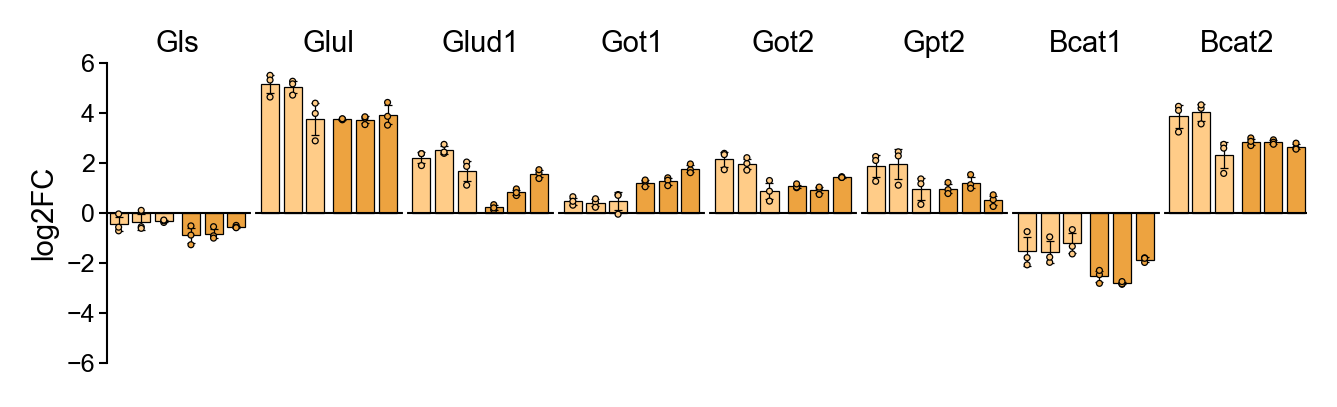

<Figure size 640x480 with 0 Axes>

In [4]:
err_kw = dict(lw=0.3, capsize=1, capthick=0.3)

sF = 1 # Size factor
wgap = 0.3
hgap = 0.6
nrow, ncol = 1, 1

fs_w = ncol*sF + (ncol-1)*wgap*sF
fs_h = nrow*sF + (nrow-1)*hgap*sF

fig = plt.figure(figsize=( fs_w*0.5*8, fs_h*1 ), dpi=300)
grid = plt.GridSpec(nrow, ncol,
                    left=0, right=1, bottom=0, top=1,
                    wspace=wgap, hspace=hgap)

ax = fig.add_subplot(grid[0,0])

v1 = ax.bar(xpos,
            yvalues,
            width= 0.8,
            edgecolor='k', lw=0.3,
            color=bar_c, 
            yerr = yerrs, error_kw=err_kw)
ax.scatter(sct_xpos, sct_ypos,
           c=sct_c, s=2,
           lw=0.3, edgecolors='k',
           zorder=3)
ax.axhline(0, c='k', lw=0.5)
for x in [5.95 + 6.7 * i for i in range(len(data))]:
    ax.axvline(x, c='w', lw=1)

ax.set_xlim(xpos[0]-0.5, xpos[-1]+0.5)
ax.set_ylim(-6,6)
ax.set_xticks([])
ax.tick_params(width=0.5, length=2, pad=1)

ax.set_ylabel('log2FC', labelpad=2)

xp = 2.6
for gene in data['gene_name']:
    ax.text(xp, 6.2, gene, ha='center', va='bottom')
    xp += 6.7

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)


plt.savefig('adi_Glu-related-genes_logFC_barplot.pdf', bbox_inches='tight')
plt.show()
plt.clf()